In [1]:
#Importing packages
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.model_selection import cross_val_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


In [2]:
#Loading dataset
data = pd.read_excel('default of credit card clients.xls', skiprows=1)

#Renaming columns for easier reference
data.columns = ["ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", 
                "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", 
                "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6", 
                "default_payment_next_month"]

#Dropping the ID column
data.drop("ID", axis=1, inplace=True)

#Previewing the dataset
print(data.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default_payment_next_month  
0     

### Data Preprocessing

In [3]:
#Handling missing values
data = data.dropna()

#Encoding categorical variables (SEX, EDUCATION, MARRIAGE)
data = pd.get_dummies(data, columns=["SEX", "EDUCATION", "MARRIAGE"], drop_first=True)

#Feature scaling

scaler = StandardScaler()
scaled_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                   "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
data[scaled_features] = scaler.fit_transform(data[scaled_features])

#Previewing the preprocessed data
print(data.head())

   LIMIT_BAL       AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0  -1.136720 -1.246020      2      2     -1     -1     -2     -2  -0.642501   
1  -0.365981 -1.029047     -1      2      0      0      0      2  -0.659219   
2  -0.597202 -0.161156      0      0      0      0      0      0  -0.298560   
3  -0.905498  0.164303      0      0      0      0      0      0  -0.057491   
4  -0.905498  2.334029     -1      0     -1      0      0      0  -0.578618   

   BILL_AMT2  ...  SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  EDUCATION_4  \
0  -0.647399  ...      1            0            1            0            0   
1  -0.666747  ...      1            0            1            0            0   
2  -0.493899  ...      1            0            1            0            0   
3  -0.013293  ...      1            0            1            0            0   
4  -0.611318  ...      0            0            1            0            0   

   EDUCATION_5  EDUCATION_6  MARRIAGE_1  MAR

### Exploratory Data Analysis

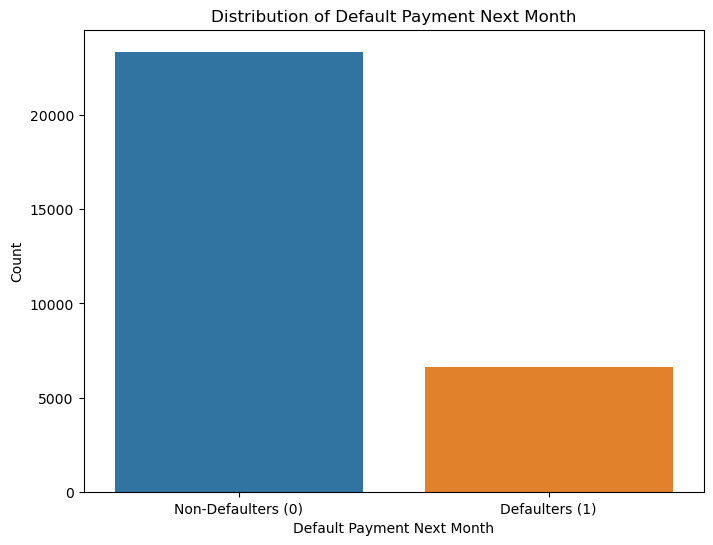

In [4]:
#Visualizing default status distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='default_payment_next_month', data=data)
ax.set_xticklabels(['Non-Defaulters (0)', 'Defaulters (1)'])
plt.xlabel('Default Payment Next Month')
plt.ylabel('Count')
plt.title('Distribution of Default Payment Next Month')
plt.show()

#### Insights from the Graph
The graph shows a significant class imbalance, with many more non-defaulters (0) than defaulters (1). This is a common scenario in credit risk datasets, where the majority of customers do not default on their payments.

Class imbalance can affect the performance of predictive models. Models may become biased towards the majority class (non-defaulters) and may not perform well in identifying the minority class (defaulters).To address this we will be taking the following measures
- Using Appropriate Metrics: 
    Instead of accuracy, we will be using metrics such as precision, recall, F1-score, and ROC-AUC to evaluate model performance.
- Using Algorithms that Handle Imbalance:
    Some algorithms and techniques are designed to handle imbalanced datasets better (e.g., ensemble methods like Random Forest, XGBoost).

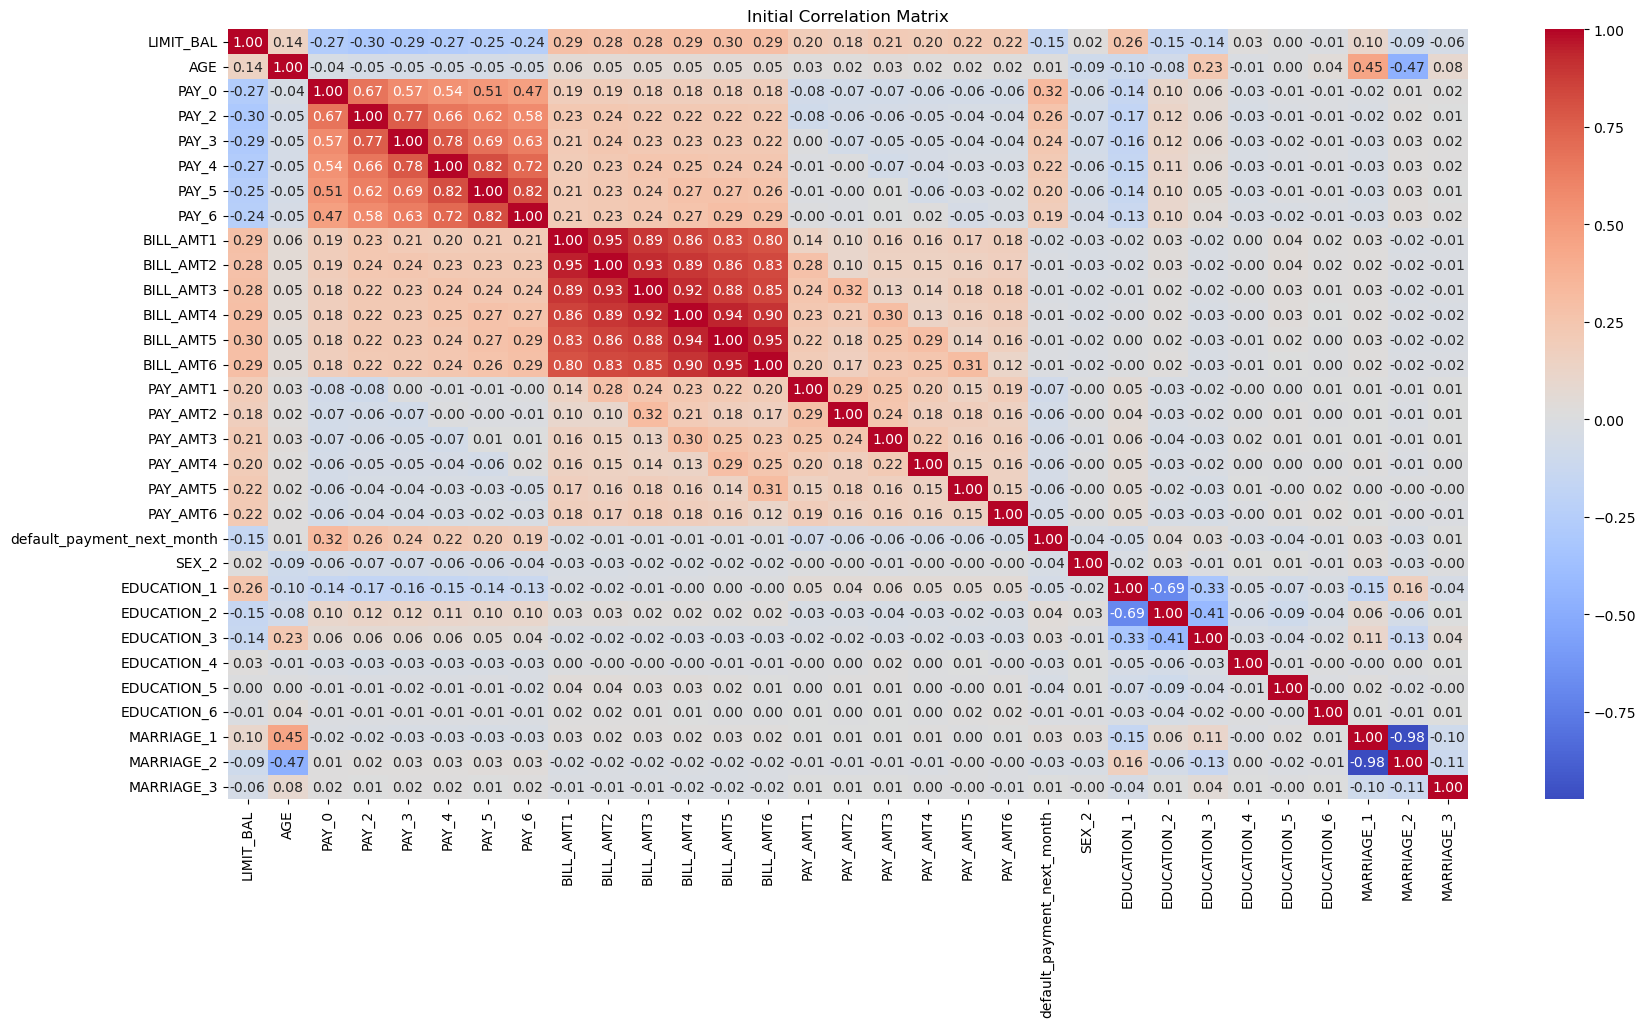

In [5]:
# Initial Correlation Matrix
plt.figure(figsize=(20, 10))
corr_matrix_initial = data.corr()
sns.heatmap(corr_matrix_initial, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Initial Correlation Matrix')
plt.show()

In [6]:
#Creating a new feature for the total bill amount over six months
data['total_bill_amt'] = data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

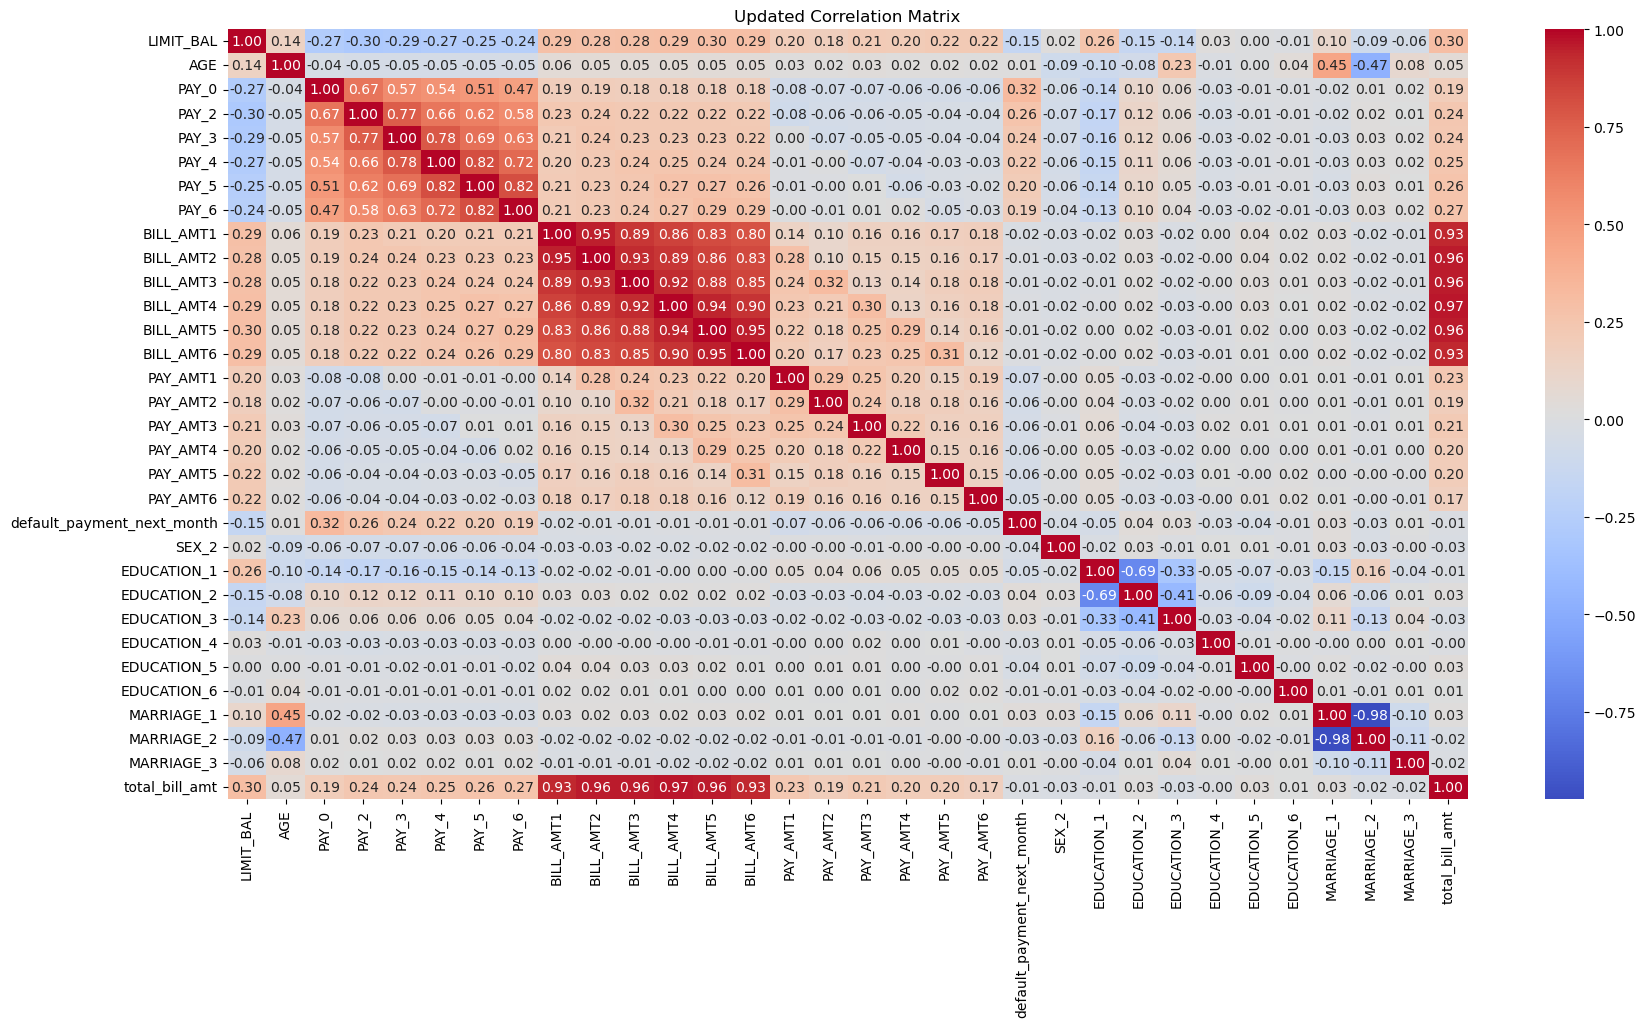

In [7]:
#Updated Correlation Matrix
plt.figure(figsize=(24, 12))
corr_matrix_updated = data.corr()
sns.heatmap(corr_matrix_updated, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Updated Correlation Matrix')
plt.show()


### Model Building 

In [8]:
#Defining features and target
X = data.drop('default_payment_next_month', axis=1)
y = data['default_payment_next_month']

#Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialising Logistic Regression Model
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
log_reg.fit(X_train, y_train)

#Initialising Random Forest Model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

#Intiitalising XGBoost Model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Evaluation

In [9]:
#Function to calculate and print metrics
def calculate_metrics(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("\n") 
    return accuracy, precision, recall, roc_auc

#Calculating metrics for each model
log_reg_metrics = calculate_metrics(log_reg, X_test, y_test, "Logistic Regression")
rf_metrics = calculate_metrics(rf, X_test, y_test, "Random Forest")
xgb_metrics = calculate_metrics(xgb_model, X_test, y_test, "XGBoost")


Logistic Regression Metrics:
Accuracy: 0.81
Precision: 0.70
Recall: 0.24
ROC-AUC: 0.61


Random Forest Metrics:
Accuracy: 0.81
Precision: 0.63
Recall: 0.36
ROC-AUC: 0.65


XGBoost Metrics:
Accuracy: 0.81
Precision: 0.64
Recall: 0.36
ROC-AUC: 0.65




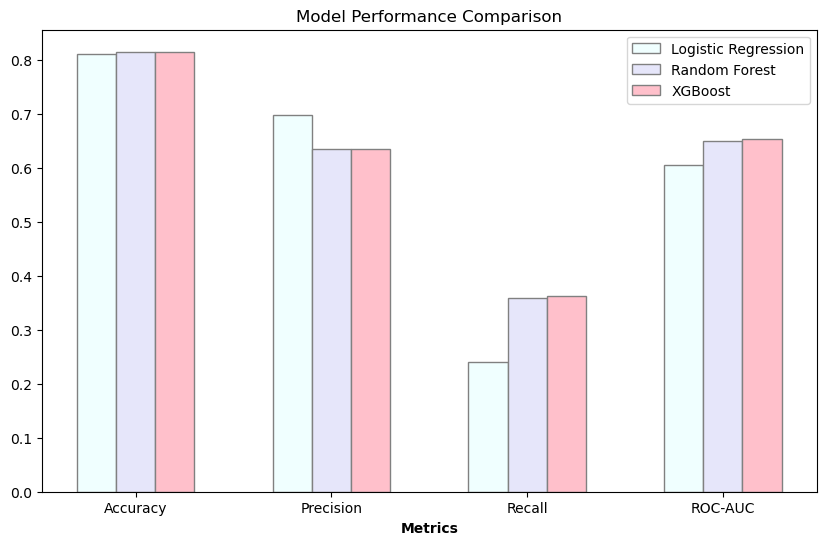

In [10]:
#Defining the metrics and model names
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
log_reg_scores = log_reg_metrics
rf_scores = rf_metrics
xgb_scores = xgb_metrics

bar_width = 0.2

#Setting positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

#Creating the bar charts
plt.figure(figsize=(10, 6))

plt.bar(r1, log_reg_scores, color='azure', width=bar_width, edgecolor='grey', label='Logistic Regression')
plt.bar(r2, rf_scores, color='lavender', width=bar_width, edgecolor='grey', label='Random Forest')
plt.bar(r3, xgb_scores, color='pink', width=bar_width, edgecolor='grey', label='XGBoost')

#Adding xticks on the middle of the group bars
plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)

#Adding title and legend
plt.title('Model Performance Comparison')
plt.legend()

plt.show()

### Analysing Performance Metrics

#### Metrics Breakdown:
1. **Accuracy**:
   - All three models (Logistic Regression, Random Forest, XGBoost) have very similar accuracy scores, with values around 0.8.

2. **Precision**:
   - Logistic Regression has the highest precision, which means it is better at correctly identifying positive instances (defaulters) without many false positives.
   - Random Forest and XGBoost have slightly lower precision.

3. **Recall**:
   - Random Forest and XGBoost have higher recall compared to Logistic Regression. Recall measures the model's ability to identify all actual positive instances (defaulters). Higher recall means fewer false negatives.

4. **ROC-AUC**:
   - All three models have similar ROC-AUC scores, indicating they perform similarly in distinguishing between the positive class (defaulters) and the negative class (non-defaulters).

#### Model Selection Criteria:
**Use Case Importance**:
   - If the priority is **minimizing false negatives** (i.e., ensuring all defaulters are correctly identified), **recall** is more critical. In this case, Random Forest and XGBoost are preferable due to their higher recall scores.
   - If the priority is **minimizing false positives** (i.e., not incorrectly labeling non-defaulters as defaulters), **precision** is more critical. In this case, Logistic Regression is preferable due to its higher precision score.

- **XGBoost**: Given its balance between precision and recall, XGBoost would be a good choice for this task. It has competitive precision and recall, ensuring a good balance between minimizing both false positives and false negatives.

### Hyperparameter tuning

In [11]:
#Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#Initializing the model
xgb_model = xgb.XGBClassifier(random_state=42)

#Initializing GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

#Fitting the model
grid_search.fit(X_train, y_train)

#Getting the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


### Model Evaluation using updated Hyperparameters

In [12]:
#Initializing the model with the best parameters
xgb_best = xgb.XGBClassifier(**best_params, random_state=42)

#Performing cross-validation
cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='roc_auc')

#Printing the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean ROC-AUC score: {cv_scores.mean()}")

Cross-validation scores: [0.78725387 0.7866647  0.78567315 0.77982013 0.77441296]
Mean ROC-AUC score: 0.7827649596318678


### Feature importance

<Figure size 1000x800 with 0 Axes>

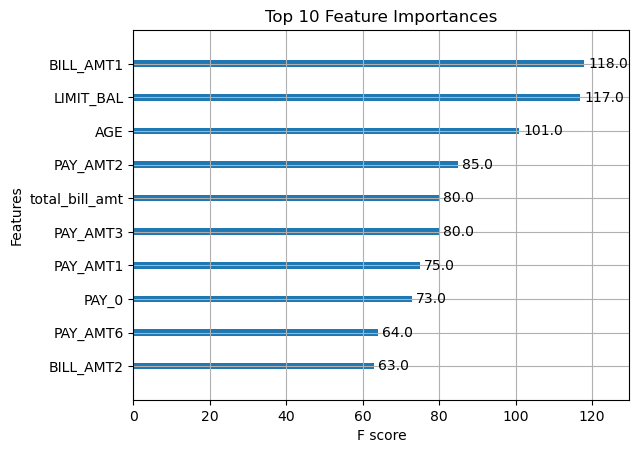

In [13]:
#Fitting the model with the best parameters
xgb_best.fit(X_train, y_train)

#Plotting feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_best, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


### Final Model Evaluation

Accuracy: 0.82
Precision: 0.66
Recall: 0.36
ROC-AUC: 0.78


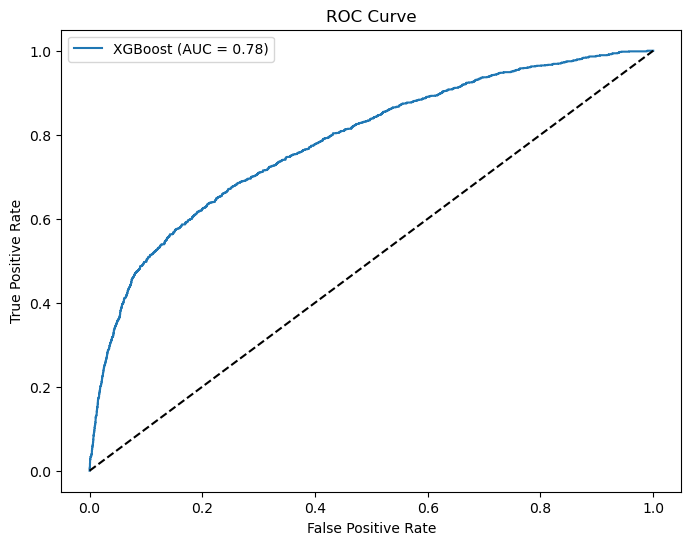

In [14]:
#Making predictions
y_pred = xgb_best.predict(X_test)
y_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

#Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Printing metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

#Plotting ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

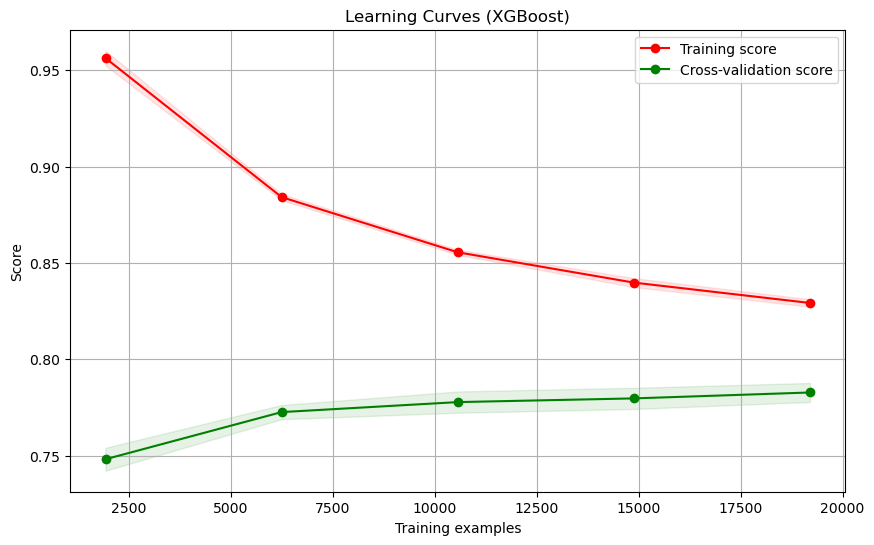

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estima

In [15]:
#Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5), scoring='roc_auc'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

#Plotting learning curve
plot_learning_curve(xgb_best, "Learning Curves (XGBoost)", X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc')
plt.show()

#### Interpretation of the Learning Curves:

#### Key Observations:

1. **Training Score**:
   - The training score starts high and gradually decreases as the number of training examples increases.
   - This is expected behavior as the model is exposed to more data and finds it harder to fit perfectly.

2. **Cross-Validation Score**:
   - The cross-validation score starts lower and gradually increases as the number of training examples increases.
   - This indicates that the model is generalizing better with more data.

3. **Gap Between Curves**:
   - There is a noticeable gap between the training score and cross-validation score.
   - A large gap can indicate overfitting, where the model performs well on the training data but not as well on unseen data.


#### Overfitting:
- The model shows some degree of overfitting, as evidenced by the gap between the training and cross-validation scores.
- However, the gap is not excessively large, and the cross-validation score does improve with more training examples, indicating the model is learning and generalizing better with more data.

#### Cross-Validation Score:
- The cross-validation score stabilizes around 0.8 indicating that the model has a good ability to discriminate between defaulters and non-defaulters.